# Study of the Swiss electrical mix (and imports) between 2016 and 2024

This notebook is a study of the Swiss electrical mix (production and imports) between 2016 and 2024. It aims to represent the repartition of the consumed electricity and the associated ghg emissions.
It illustrates some possible uses of EcoDynElec.

We perform a historical analysis of the Swiss energy mix over 8 years, between 2016 and 2024. We have hourly European electricity production and exchange data, from which we calculate the Swiss electricity mix and its carbon impact (in grams of CO2 per kWh).
We mainly use two information types:
- The **producer mix** refers to the electricity produced in the designated country. It contains only local sources. When converting the producer mix into kWh, we obtain the **electricity production** of the country.
- The **consumer mix** refers to the electricity consumed in the designated country. It contains local sources as well as the import of electricity from other countries. When converting the consumer mix into kWh, we obtain the **electricity consumption** of the country.

These data make it possible to calculate the **carbon impact hour by hour** of the electricity produced and consumed in the country (these two impacts are therefore different), and then to study the sources of these emissions.

## 0. Configuring EcoDynElec and loading the data

In [1]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, r"C:\Users\PC Jules\Desktop")

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from ecodynelec.preprocessing.downloading import download #import the class to download entsoe data
from EcoDynElec.examples.mix_analysis.analysis_functions import format_data_0, get_metrics, plot_hourly_heatmap, plot_years, \
    plot_typical_days

# change plt font size
plt.rcParams.update({'font.size': 12})

In [2]:
# EcoDynElec configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH']  # You can put multiple targets here
# Enable this if you want to plot fig 6 (will impact the computation time - it took me 15min)
my_config.target = ['CH', 'AT', 'FR', 'DE','IT']
my_config.data_cleaning = True
my_config.sg_imports = True

# Indicate where to save generation data
my_config.path.generation = "./test_data/downloads/generations/"
# Indicate where to save exchange data
my_config.path.exchanges = "./test_data/downloads/exchanges/"
# Recommended config: include swiss grid residual (difference between swiss grid and entso-e data)
my_config.residual_global = True
# Recommended config: include real (2020-2022) and estimated (2016-2019) renewable production (using EcoDynElec-Enr-Model)
my_config.ch_enr_model_path = '../support_files/enr_prod_2016-2024_completed.csv'

# Years to study
years = ['2016','2017','2018', '2019', '2020', '2021', '2022', '2023', '2024']

#### 0.1 Download and generate data files
This can done once, then the electrical mix and impact files will be saved and can be loaded directly (see 0.2)

In [3]:
# Data downloading configuration
### Set the dates (to select files to download)
my_config.start = '2016-01-01 00:00:00'
my_config.end = '2024-12-31 23:45:00'

### Configure the server connection
my_config.server.useServer = False # Turn it to True if you want to download data from the server
### Credentials
my_config.server.username = 'jules.courrian@heig-vd.ch'
my_config.server.password = 'XXXXXXXXX'
# Download the data 
#download(my_config, threshold_minutes=15, threshold_size=0.9, is_verbose=True)

If examples/test_data/downloads and examples/mix_analysis/results_local_all_enr are not empty, there is no need to execute the cell below.

In [4]:
from EcoDynElec.examples.mix_analysis.analysis_functions import generate_data

#Allows to run this notebook from another notebook without generating the data again (using %run)
if 'skip_generation' not in globals():
    flows, prods, mixs, prod_impacts, impacts = generate_data(my_config, years,
                                                              savedir="./mix_analysis/results_local_all_enr/")
else:
    print("Skipping data generation")

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\pipeline_functions.py:116: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sg_data = sg_data.resample(p.freq).sum()
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\auxiliary.py:423: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  enr_prod_ch = enr_prod_ch.loc[start + pd.Timedelta('1H'):end + pd.Timedelta('1H')] / 1000  # Convert from kWh to MWh
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\auxiliary.py:433: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  enr_prod_ch.index = enr_prod_ch.index - pd.Timedelta('1H')  # Shift the index to the left
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\auxiliary.py:435: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  enr_prod_ch = enr_prod_

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead o

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:125: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return resolution.fillna(method='ffill').fillna(method='bfill')
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:208: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return obj.resample(freq).asfreq() # Resample with original frequency
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  return dtype( pd.Timedelta('1H') / pd.Timedelta(frequency) ) # Return nb of steps per hour
C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\preprocessing\autocomplete.py:172: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' inste

C:\Users\PC Jules\Desktop\EcoDynElec\ecodynelec\impacts.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[[1.40899464e-01 4.72879549e-03 2.52291589e-04 8.40361714e-02]
 [6.09000027e-01 4.92999982e-03 1.51000000e-04 2.02000001e-03]
 [7.99999982e-02 6.91000000e-03 7.65000004e-05 4.93999990e-03]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [3.50000011e-03 1.82000000e-03 7.48000002e-06 1.61000004e-04]
 [6.15999987e-03 1.87000004e-03 8.87999977e-06 9.39000020e-05]
 [5.61720738e-03 2.91767414e-03 1.57767408e-05 2.80011474e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19005179e-02 1.51257375e-02 5.94841331e-05 1.58950686e-03]
 [8.44450369e-02 1.21740801e-02 2.20234127e-04 2.64690164e-03]
 [8.09478512e-02 1.23245791e-02 2.11242892e-04 2.58667994e-03]]' has dtype incompatible with float32, please expli

#### 0.2 Load data from saved files
If the files for the years of interest have already been generated, they can be loaded directly in this section

In [5]:
from EcoDynElec.examples.mix_analysis.analysis_functions import load_data

flows, prods, mixs, prod_impacts, impacts = load_data(my_config.target, my_config.freq, years,
                                                      savedir="./mix_analysis/results_local_all_enr/")

### 0.3 Pre-processing the data
Here we reformat the data to make it easier to manipulate and plot

In [6]:
from EcoDynElec.examples.mix_analysis.analysis_functions import concatenate_and_format_data

# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country
raw_productions_by_src, raw_consumptions_by_src, electricity_prod_mixs, electricity_mixs, producing_electricity_impacts, electricity_impacts = concatenate_and_format_data(my_config.target, years, flows, prods, mixs, prod_impacts, impacts)

# Extract the data for CH
raw_production_by_src = raw_productions_by_src['CH']
raw_consumption_by_src = raw_consumptions_by_src['CH']
electricity_prod_mix = electricity_prod_mixs['CH']
electricity_mix = electricity_mixs['CH']
electricity_impact = electricity_impacts['CH']
producing_electricity_impact = producing_electricity_impacts['CH']

### 0.4 Plots configuration

Some color codes for each country

In [7]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'gray',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
colormap_extended = colormap | {
    'Nuclear_CH': '#8c564b',
    'Residual_Hydro_Run-of-river_and_poundage_CH': '#000080',  # Couleur bleu marine
    'Residual_Hydro_Water_Reservoir_CH': '#004090',  # Couleur bleu marine
    'Hydro_Water_Reservoir_CH': '#98df8a',
    'Residual_Other_CH': '#ffbb78',
    'Hydro_Pumped_Storage_CH': '#bcbd22',
    'Hydro_Run-of-river_and_poundage_CH': '#17becf',
    'Solar_CH': '#d62728',
    'Other_CH': '#1f77b4'
}
ordered_colors = [colormap[c] for c in ordered_countries]

## 1. Inter-annual analysis

Swiss annual electricity consumption

In [8]:
yearly_cons = raw_consumption_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_cons.index = pd.Series(years)
print('Consumption:')
print(yearly_cons)

yearly_prod = raw_production_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_prod.index = pd.Series(years)
print('Production:')
print(yearly_prod)

Consumption:
2016    63369.65 GWh
2017    64457.44 GWh
2018    63657.23 GWh
2019    63477.59 GWh
2020    62453.90 GWh
2021    64459.43 GWh
2022    64723.84 GWh
2023    62097.06 GWh
2024    61650.26 GWh
dtype: object
Production:
2016    58955.51 GWh
2017    58415.07 GWh
2018    64931.10 GWh
2019    69351.62 GWh
2020    67651.79 GWh
2021    61563.38 GWh
2022    60791.78 GWh
2023    67966.58 GWh
2024    75570.85 GWh
dtype: object


C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\500226334.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_cons = raw_consumption_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\500226334.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_prod = raw_production_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')


Monthly electricity consumption in 2021

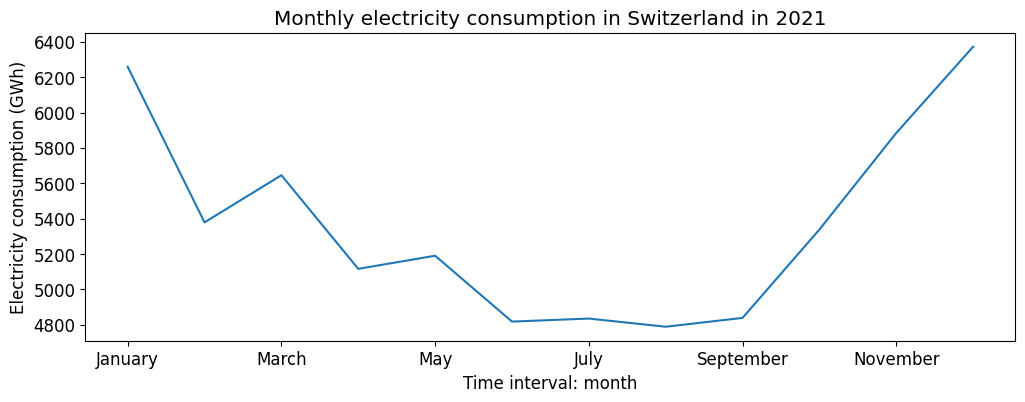

In [9]:
monthly_cons = raw_consumption_by_src['raw_df']
monthly_cons = monthly_cons.loc[[d.year == 2021 for d in monthly_cons.index]]
monthly_cons = monthly_cons.resample('ME').sum().sum(axis=1).map(
    lambda x: x / 1000)  #.map(lambda x: f'{x / 1000:.2f} GWh')
monthly_cons.index = [f'{d.month_name()}' for d in monthly_cons.index]
#print(monthly_prod)
monthly_cons.plot(figsize=(12, 4), title='Monthly electricity consumption in Switzerland in 2021')
plt.xlabel('Time interval: month')
plt.ylabel('Electricity consumption (GWh)');

2021 Monthly production from selected sources (helps to validate the data)

In [10]:
from ecodynelec.pipeline_functions import get_producing_mix_kwh, get_consuming_mix_kwh

ch_prod_raw = {}
# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for y in years:
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y]['CH'], prod_mix_df=prods[y]['CH'])
else:
    for y in years:
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y], prod_mix_df=prods[y])
ch_prod_raw = format_data_0({y: ch_prod_raw[y] for y in years})['raw_df']
cols = ['Solar_CH', 'Nuclear_CH',
        'Wind_Onshore_CH']  # ['Residual_Hydro_Water_Reservoir_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Other_CH'] ...
start = '2021-01-01'
end = '2021-12-31'
monthly_prod = ch_prod_raw[cols][start:end].resample('ME').sum()
del ch_prod_raw
monthly_prod / 1000

,Solar_CH,Nuclear_CH,Wind_Onshore_CH
2021-01-31,32.499965,2164.080902,15.736622
2021-02-28,109.200111,1968.810795,16.019753
2021-03-31,246.800020,2212.902509,11.657252
2021-04-30,346.699871,2145.929602,11.077237
2021-05-31,357.000261,1605.901801,16.368286
2021-06-30,443.900116,630.387396,6.827212
2021-07-31,356.499684,1257.923598,8.731561
2021-08-31,352.500202,1038.537602,9.149183
2021-09-30,283.999992,1118.357298,6.731686
2021-10-31,196.000480,1279.977801,12.501000


Main power sources in the Swiss electricity mix

In [11]:
yearly_mix = electricity_mix['raw_df'].resample('YE').mean()
local_cols = yearly_mix.mean().nlargest(20).index.tolist()
yearly_mix = yearly_mix.applymap(lambda x: f'{x * 100:.0f} %')
yearly_mix.index = pd.Series(years)
print(yearly_mix[local_cols])

     Nuclear_CH Residual_Hydro_Run-of-river_and_poundage_CH  \
2016       21 %                                        16 %   
2017       21 %                                        15 %   
2018       26 %                                        15 %   
2019       27 %                                        15 %   
2020       25 %                                        17 %   
2021       20 %                                        15 %   
2022       26 %                                        12 %   
2023       25 %                                        15 %   
2024       23 %                                        15 %   

     Hydro_Water_Reservoir_CH Nuclear_FR Hydro_Pumped_Storage_CH  \
2016                      8 %        7 %                     5 %   
2017                      9 %        7 %                     6 %   
2018                     10 %        6 %                     7 %   
2019                     12 %        7 %                     7 %   
2020                     12 %

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\3517889561.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yearly_mix = yearly_mix.applymap(lambda x: f'{x * 100:.0f} %')


Consumed electricity by country of origin and associated GHG emissions, monthly view

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\4199006372.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('M').sum() / 1000


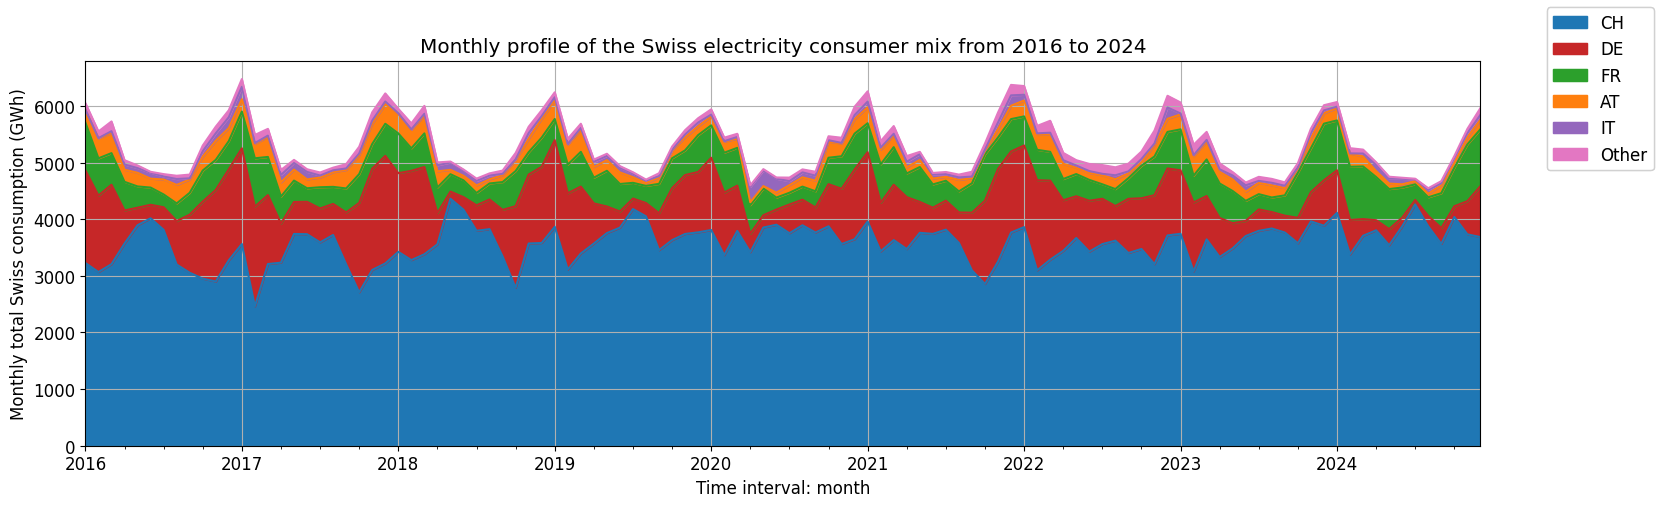

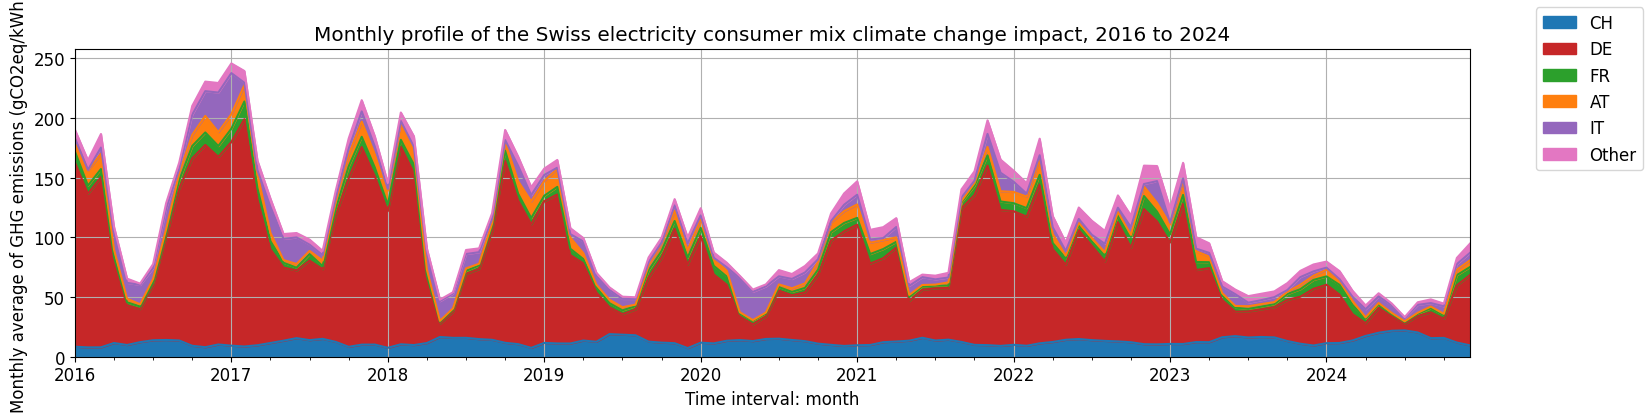

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 5))
ax1.set_title("Monthly profile of the Swiss electricity consumer mix from 2016 to 2024")
mix_import = electricity_mix['df'].drop(['sum'], axis=1)
mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('M').sum() / 1000
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: month')
ax1.set_ylabel('Monthly total Swiss consumption (GWh)')
#plot_years()
fig.legend()
fig.legend()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Monthly profile of the Swiss electricity consumer mix climate change impact, 2016 to 2024")
mix_import = electricity_impact['df'].drop(['sum'], axis=1)
mix_import = mix_import.resample('ME').mean()
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: month')
ax1.set_ylabel('Monthly average of GHG emissions (gCO2eq/kWh)')
#plot_years()
fig.legend()
plt.grid(True)
plt.show()

Consumed electricity by country of origin and associated GHG emissions, weekly view

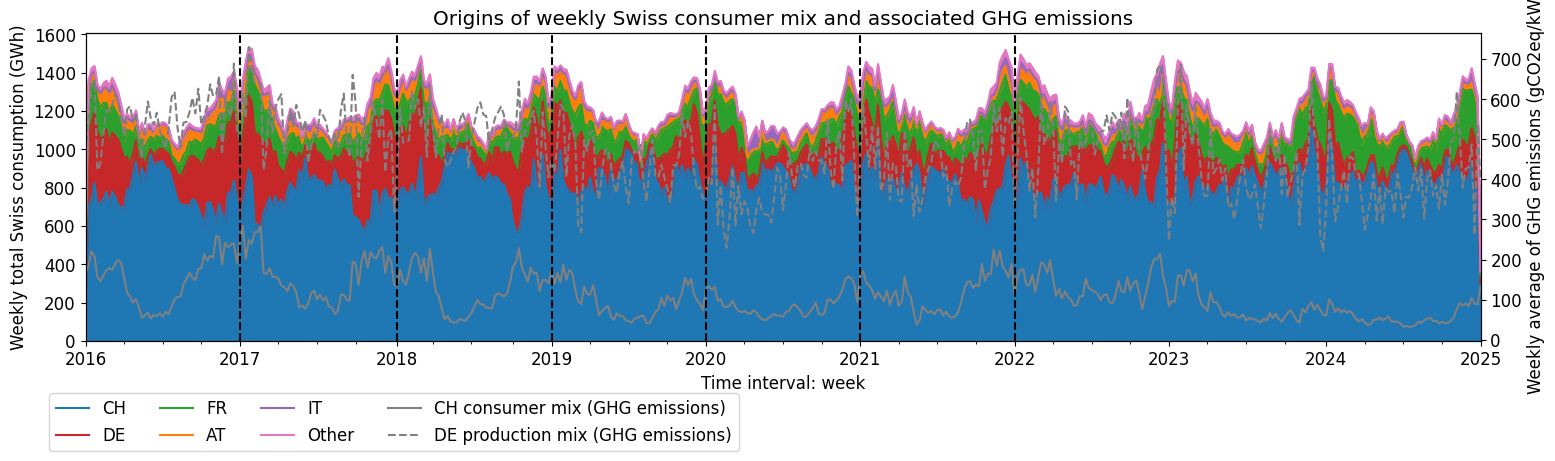

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Origins of weekly Swiss consumer mix and associated GHG emissions")
mix_import = electricity_mix['df'].drop(['sum'], axis=1)
mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('W').sum() / 1000
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('Weekly total Swiss consumption (GWh)')

ax2 = ax1.twinx()
ch_consumer_impact = (electricity_impact['df']['sum']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
ch_consumer_impact.plot(ax=ax2, linestyle='-', color=[colormap['sum']])
de_producing_impact = (producing_electricity_impacts['DE']['df']['sum']).resample(
    'W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
de_producing_impact.plot(ax=ax2, linestyle='--', color=[colormap['sum']])
ax2.set_ylabel('Weekly average of GHG emissions (gCO2eq/kWh)')

plot_years()

fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
           np.concatenate([ax1.get_legend_handles_labels()[1],
                           ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
           loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

In [14]:
mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('YE').sum() / 1000
pd.DataFrame(mix_import)

,AT,CH,DE,FR,IT,Other
2016-12-31,20068.909422,253504.579905,79384.720099,37135.120966,5505.556507,6717.310055
2017-12-31,22422.640924,267891.823386,99365.184076,41172.049302,6191.564777,8412.039836
2018-12-31,17373.791364,282132.725769,77064.389511,35269.014065,4424.688813,5929.153559
2019-12-31,16889.019959,296620.204639,66686.412710,38887.561953,4043.772632,4601.242850
2020-12-31,13134.995851,300739.732365,57977.918119,37936.647555,7861.098102,5237.300312
2021-12-31,13683.824177,292747.788826,81505.276116,44527.020492,6315.997939,9048.204109
2022-12-31,16151.473221,290242.724704,89967.381175,39162.031365,5153.848679,12986.770420
2023-12-31,16648.951058,287689.701612,50698.292559,46969.095218,3620.300506,8143.884140
2024-12-31,10027.979237,291797.499567,30230.718470,57721.536410,4869.312777,4310.361292
2025-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Impact of the Swiss consumer mix per country producing the electricity

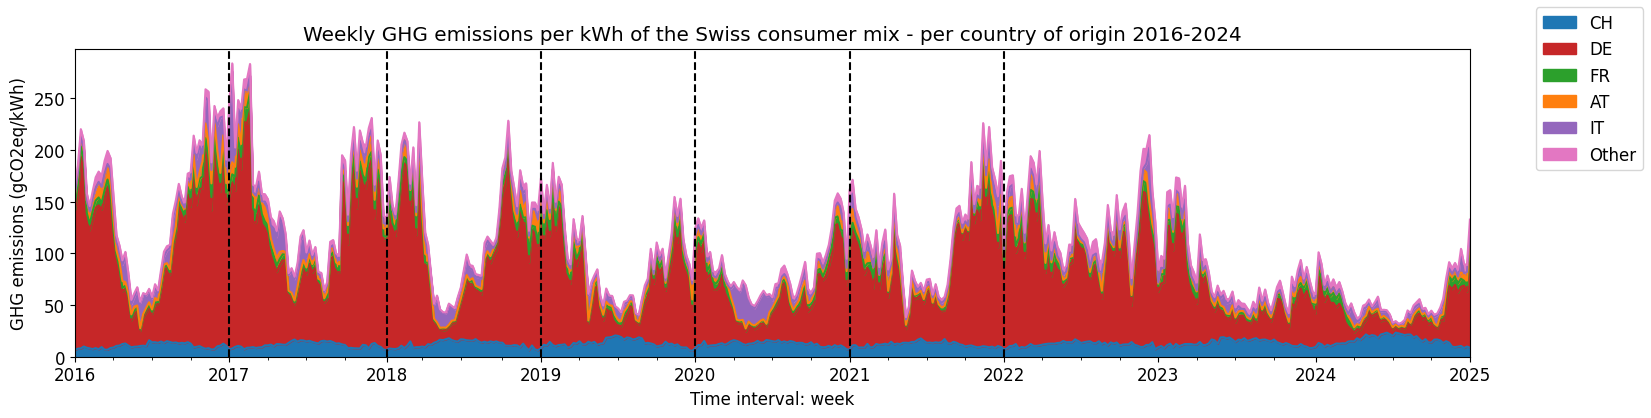

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Weekly GHG emissions per kWh of the Swiss consumer mix - per country of origin 2016-2024")
impc = electricity_impact['df'].drop(['sum'], axis=1)
impc = impc.resample('W').mean()
impc[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('GHG emissions (gCO2eq/kWh)')
plot_years()
fig.legend();

Impact of the Swiss consumer mix aggregated per electricity production type

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\2719440552.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es13_per_type_10['Other sources'] = es13_per_type.sum(axis=1) - es13_per_type_10.sum(axis=1)


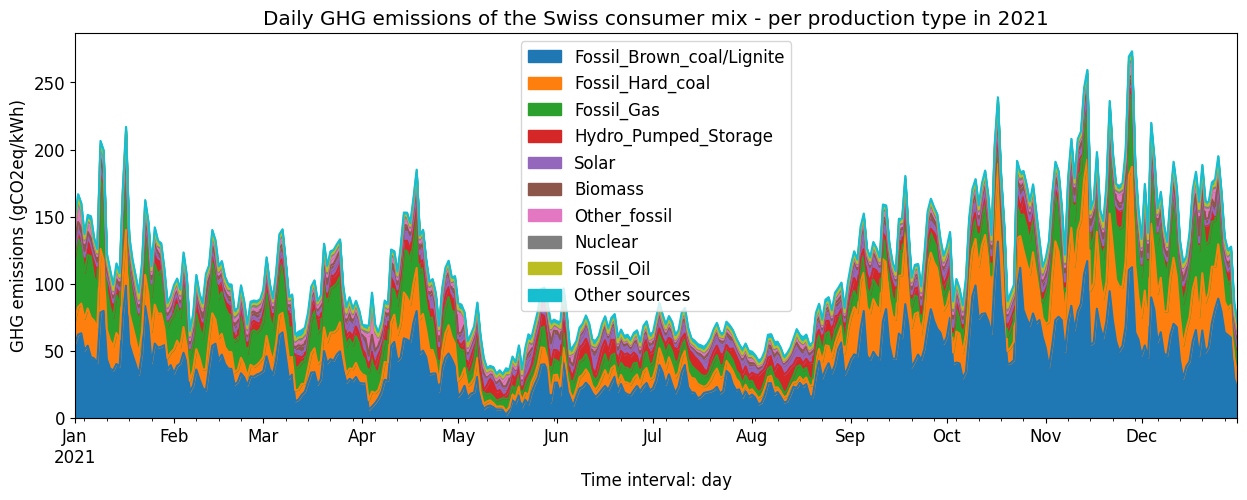

In [16]:
def compute_per_type(results):
    """Function to group datasets per type of unit, regardless of the country of origin"""
    unit_list = np.unique(
        [k[:-3] if k[-3] == "_" else k for k in results.columns])  # List the different production units

    per_unit = []
    for u in unit_list:
        cols = [k for k in results.columns if k[:-3] == u]  # collect the useful columns
        per_unit.append(pd.Series(results.loc[:, cols].sum(axis=1), name=u))  # aggregate

    return pd.concat(per_unit, axis=1)
electricity_impact['raw_df'][electricity_impact['raw_df'] < 0] = 0
imp = electricity_impact['raw_df'].loc['2021'].resample('D').mean()
es13_per_type = compute_per_type(imp)  # Group Climate Change index impacts per country
local_cols = es13_per_type.mean().nlargest(9).index.tolist()
es13_per_type_10 = es13_per_type[local_cols]
es13_per_type_10['Other sources'] = es13_per_type.sum(axis=1) - es13_per_type_10.sum(axis=1)
es13_per_type_10.plot.area(figsize=(15, 5),
                           title="Daily GHG emissions of the Swiss consumer mix - per production type in 2021")  # Build the graph

plt.xlabel('Time interval: day')
plt.ylabel('GHG emissions (gCO2eq/kWh)');

Mix by source (import source and main CH production sources)

lc cols ['Nuclear_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Hydro_Water_Reservoir_CH', 'Hydro_Pumped_Storage_CH', 'Residual_Hydro_Water_Reservoir_CH', 'Solar_CH']


C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\3777465185.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_consumption = raw_consumption_by_src['df']['sum'].resample('Y').sum() / 1e6


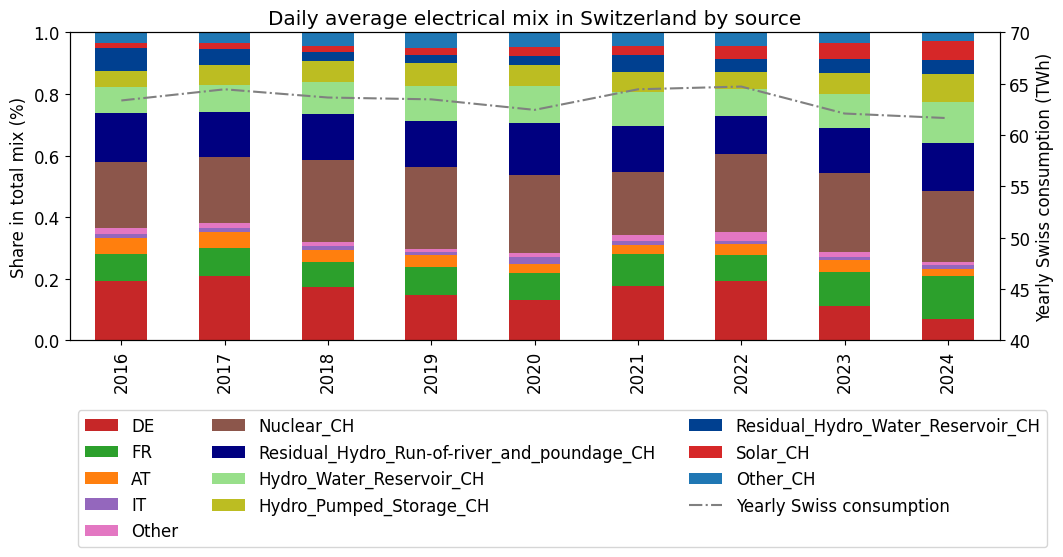

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

# import mix
compute_mix = electricity_mix['df'][ordered_countries].drop('CH', axis=1)
# local CH mix
local_mix = electricity_mix['raw_df']  # wtf .resample('W').mean()
local_mix = local_mix.drop(local_mix.loc[:, [not k.endswith('CH') or 'Mix' in k for k in local_mix.columns]], axis=1)
local_cols = local_mix.mean().nlargest(len(ordered_countries)).index.tolist()
print('lc cols', local_cols)
local_mix['Other_CH'] = local_mix.drop(local_cols, axis=1).sum(axis=1)
# merged mix
compute_mix = pd.concat([compute_mix, local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')
colors = [colormap_extended[c] for c in compute_mix.columns]
# yearly consumption (TWh), used for comparison
yearly_consumption = raw_consumption_by_src['df']['sum'].resample('Y').sum() / 1e6
yearly_consumption.index = metric_values[metric].index  # keep same x axis
# plot
ax2 = ax.twinx()
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, color=colors, legend=True)
yearly_consumption.plot(ax=ax2, linestyle='-.', color='gray', legend=False, label='Yearly Swiss consumption')
ax.set_title(f'Daily average electrical mix in Switzerland by source')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 1)
ax2.set_ylabel('Yearly Swiss consumption (TWh)')
ax2.set_ylim(40, 70)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
handles.append(ax2.get_lines()[0])
labels.append(ax2.get_legend_handles_labels()[1][0])
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2));

Residual mix decomposition (difference between Entso-e breakdown and SwissGrid national production)

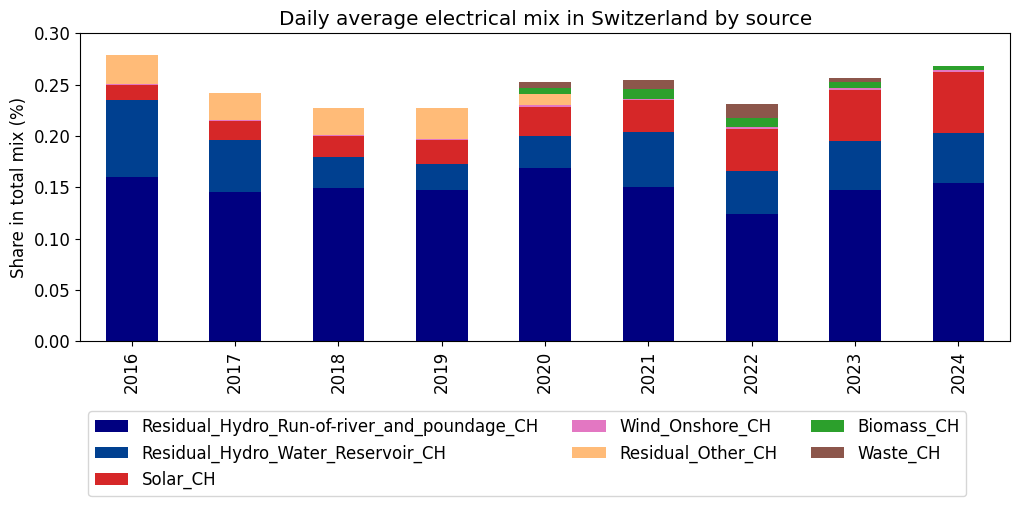

In [18]:
# local CH mix
local_cols = ['Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Hydro_Water_Reservoir_CH', 'Solar_CH', 'Wind_Onshore_CH', 'Residual_Other_CH', 'Biomass_CH', 'Waste_CH']
compute_mix = electricity_mix['raw_df'][local_cols]
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')

colormap_extended['Wind_Onshore_CH'] = colormap['Other']#'#17becf'
colormap_extended['Biomass_CH'] = colormap['FR']
colormap_extended['Waste_CH'] = colormap_extended['Nuclear_CH']
colors = [colormap_extended[c] for c in compute_mix.columns]

# plot
fig, ax = plt.subplots(figsize=(12, 4))
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, legend=True, color=colors)
ax.set_title(f'Daily average electrical mix in Switzerland by source')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 0.3)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2));

Impact of consumption mix over five years

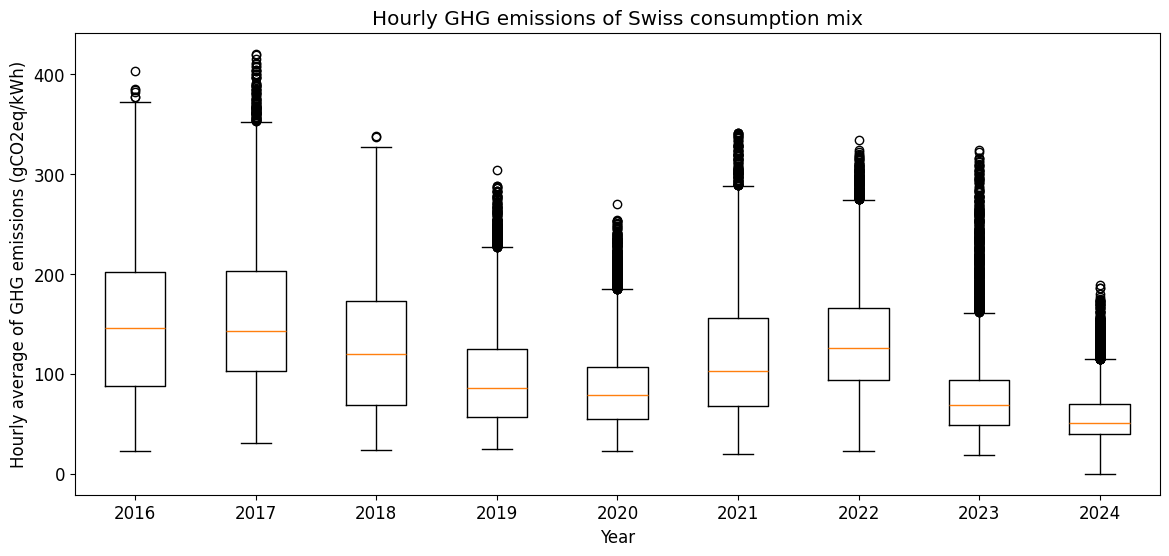

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
data = electricity_impact['df'].astype('float32')
data = pd.DataFrame(data['sum'])
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss consumption mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Impact of production mix over five years

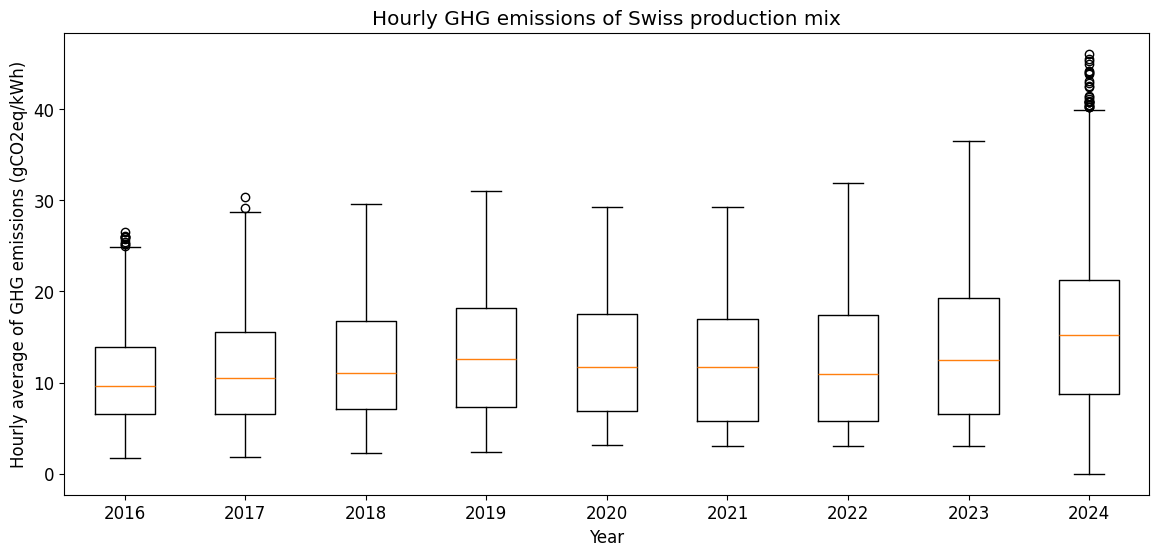

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
data = producing_electricity_impact['raw_df'].astype('float32')
data = data.drop(data.loc[:, [not k.endswith('CH') or 'Mix' in k for k in data.columns]], axis=1)
data = pd.DataFrame(data.sum(axis=1))
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss production mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Figure 6, comparison between the producing impacts of several countries and the import mix of Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

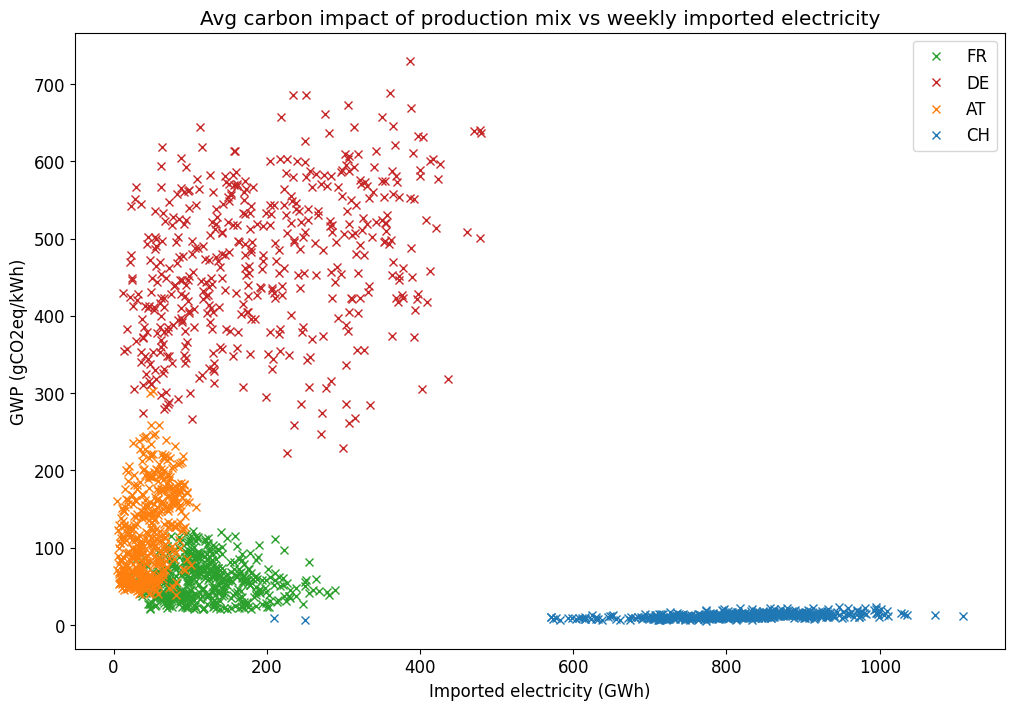

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0, 1, 100)
countries = ['FR', 'DE', 'AT', 'CH']
for c in countries:
    #mx = electricity_mixs['CH']['df'][c].resample('M').mean()
    mx = raw_consumptions_by_src['CH']['df'][c].resample('W').sum().map(lambda x: x / 1000)
    px = producing_electricity_impacts[c]['df']['sum'].resample('W').mean()
    plt.plot(mx, px, color=colormap[c], label=c, marker='x', linestyle='None')
plt.title('Avg carbon impact of production mix vs weekly imported electricity')
plt.xlabel('Imported electricity (GWh)')
plt.ylabel('GWP (gCO2eq/kWh)')
plt.legend();

Table 4, comparison between the producing impacts of several countries an the impacts of imports in Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

In [22]:
countries = ['FR', 'DE', 'AT']
table = {}
freq = 'Y'
for c in countries:
    table[c + '_prod'] = producing_electricity_impacts[c]['df']['sum'].resample(freq).mean()
for c in countries:
    emitted_co2 = producing_electricity_impacts[c]['df']['sum'].multiply(raw_consumptions_by_src['CH']['df'][c])
    emitted_co2 = emitted_co2.resample(freq).sum() / raw_consumptions_by_src['CH']['df'][c].resample(freq).sum()
    table[c + '_import'] = emitted_co2
    #table[c + '_import'] = electricity_impact['df'][c].resample(freq).mean()
tabled = pd.DataFrame(table)
for c in countries:
    tabled[c + '_diff'] = (tabled[c + '_import'].astype(float) - tabled[c + '_prod'].astype(float)) / tabled[
        c + '_prod'].astype(float) * 100
tabled = tabled.applymap(lambda val: f'{val:.2f}').T
ordered_table = tabled.loc[
    ['AT_prod', 'AT_import', 'AT_diff', 'FR_prod', 'FR_import', 'FR_diff', 'DE_prod', 'DE_import', 'DE_diff']]
ordered_table.index = ['AT production mix impact', 'Impact of AT electricity consumed in CH', 'Difference (%)',
                       'FR production mix impact', 'Impact of FR electricity consumed in CH', 'Difference (%)',
                       'DE production mix impact', 'Impact of DE electricity consumed in CH', 'Difference (%)']

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\1418842391.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  table[c + '_prod'] = producing_electricity_impacts[c]['df']['sum'].resample(freq).mean()
C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\1418842391.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  emitted_co2 = emitted_co2.resample(freq).sum() / raw_consumptions_by_src['CH']['df'][c].resample(freq).sum()
C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\1418842391.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabled = tabled.applymap(lambda val: f'{val:.2f}').T


In [23]:
ordered_table

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31,2024-12-31
AT production mix impact,127.69,128.64,124.30,129.19,118.51,122.00,126.03,96.34,93.18
Impact of AT electricity consumed in CH,130.67,135.02,146.42,130.20,117.70,134.52,134.83,93.42,90.88
Difference (%),2.33,4.97,17.80,0.78,-0.68,10.26,6.98,-3.03,-2.47
FR production mix impact,66.77,76.91,55.96,56.50,56.73,56.41,78.09,50.04,34.09
Impact of FR electricity consumed in CH,69.83,81.36,55.15,52.53,54.08,54.24,76.17,45.42,35.13
Difference (%),4.58,5.78,-1.44,-7.03,-4.67,-3.86,-2.46,-9.25,3.06
DE production mix impact,556.83,537.70,522.04,438.18,396.86,451.50,499.13,421.85,391.07
Impact of DE electricity consumed in CH,559.79,534.28,516.30,424.18,377.08,448.72,475.35,402.67,355.77
Difference (%),0.53,-0.64,-1.10,-3.20,-4.98,-0.62,-4.76,-4.55,-9.03


## 2. Annual statistics

Annual average of carbon emissions per produced kWh:

In [24]:
yearly_mean = producing_electricity_impact['df'][['sum']].groupby(producing_electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,10.525121
2017,11.485516
2018,12.133231
2019,13.167878
2020,12.510452
2021,11.874243
2022,12.062892
2023,13.467526
2024,15.885930


Annual average of carbon emissions per consumed kWh:

In [25]:
yearly_mean = electricity_impact['df'][['sum']].groupby(electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,151.389838
2017,157.503515
2018,126.860389
2019,97.245597
2020,86.431792
2021,117.124680
2022,134.512852
2023,80.368468
2024,57.995599


Quartiles and deciles of the given years

In [26]:
ges = electricity_impact['df']['sum']
ges = pd.DataFrame(ges)
ges['Annee'] = [date.year for date in ges.index]
ges.iloc[-1, 0] = ges.iloc[-2]['sum']

In [27]:
import pandas as pd

stats_dict = {'Année': [], 'Moyenne': [], 'Médiane': [], 'Quartile 1': [], 'Quartile 3': [], 'Décile 1': [], 'Décile 9': [], 'Min': [], 'Max': []}
for annee in ges['Annee'].unique():
    data_annee = ges[ges['Annee'] == annee]['sum']
    stats_dict['Année'].append(annee)
    stats_dict['Moyenne'].append(data_annee.mean())
    stats_dict['Médiane'].append(data_annee.median())
    stats_dict['Quartile 1'].append(data_annee.quantile(0.25))
    stats_dict['Quartile 3'].append(data_annee.quantile(0.75))
    stats_dict['Décile 1'].append(data_annee.quantile(0.1))
    stats_dict['Décile 9'].append(data_annee.quantile(0.9))
    stats_dict['Min'].append(data_annee.min())
    stats_dict['Max'].append(data_annee.max())

stats_df = pd.DataFrame(stats_dict)
#stats_df.to_csv('EDE_CH_stats_gwp_2016_2022.csv')
stats_df

,Année,Moyenne,Médiane,Quartile 1,Quartile 3,Décile 1,Décile 9,Min,Max
0,2016,151.389838,145.446723,87.879582,201.869553,58.061455,250.676469,23.191311,402.911192
1,2017,157.503515,143.152421,102.436581,202.775726,73.559775,266.861812,31.200417,420.472612
2,2018,126.860389,119.385093,69.162623,172.539427,46.671522,218.709095,23.898974,338.464036
3,2019,97.245597,85.718849,56.836955,124.791128,42.907935,171.058764,24.557985,304.369988
4,2020,86.431792,79.111823,54.521887,106.647697,42.459600,141.072597,22.397894,269.723544
5,2021,117.124680,103.109604,67.766262,156.011657,48.792360,206.572620,20.188120,341.069517
6,2022,134.512852,125.965166,94.129645,166.220847,67.454663,213.890113,22.720711,333.903838
7,2023,80.368468,68.426249,49.031981,94.099682,37.915171,137.758536,19.216333,323.961432
8,2024,58.008506,50.628091,40.093656,70.021349,32.695742,93.030805,16.987597,188.477269


## 3. Intra-annual analysis

Heatmaps of :
- CH consumption
- DE and FR imports
- Consumption from hydro production (pumped storage and water reservoir)

The exported electricity is not taken into account in these figures.

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_6800\3509768761.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)


KeyboardInterrupt: 

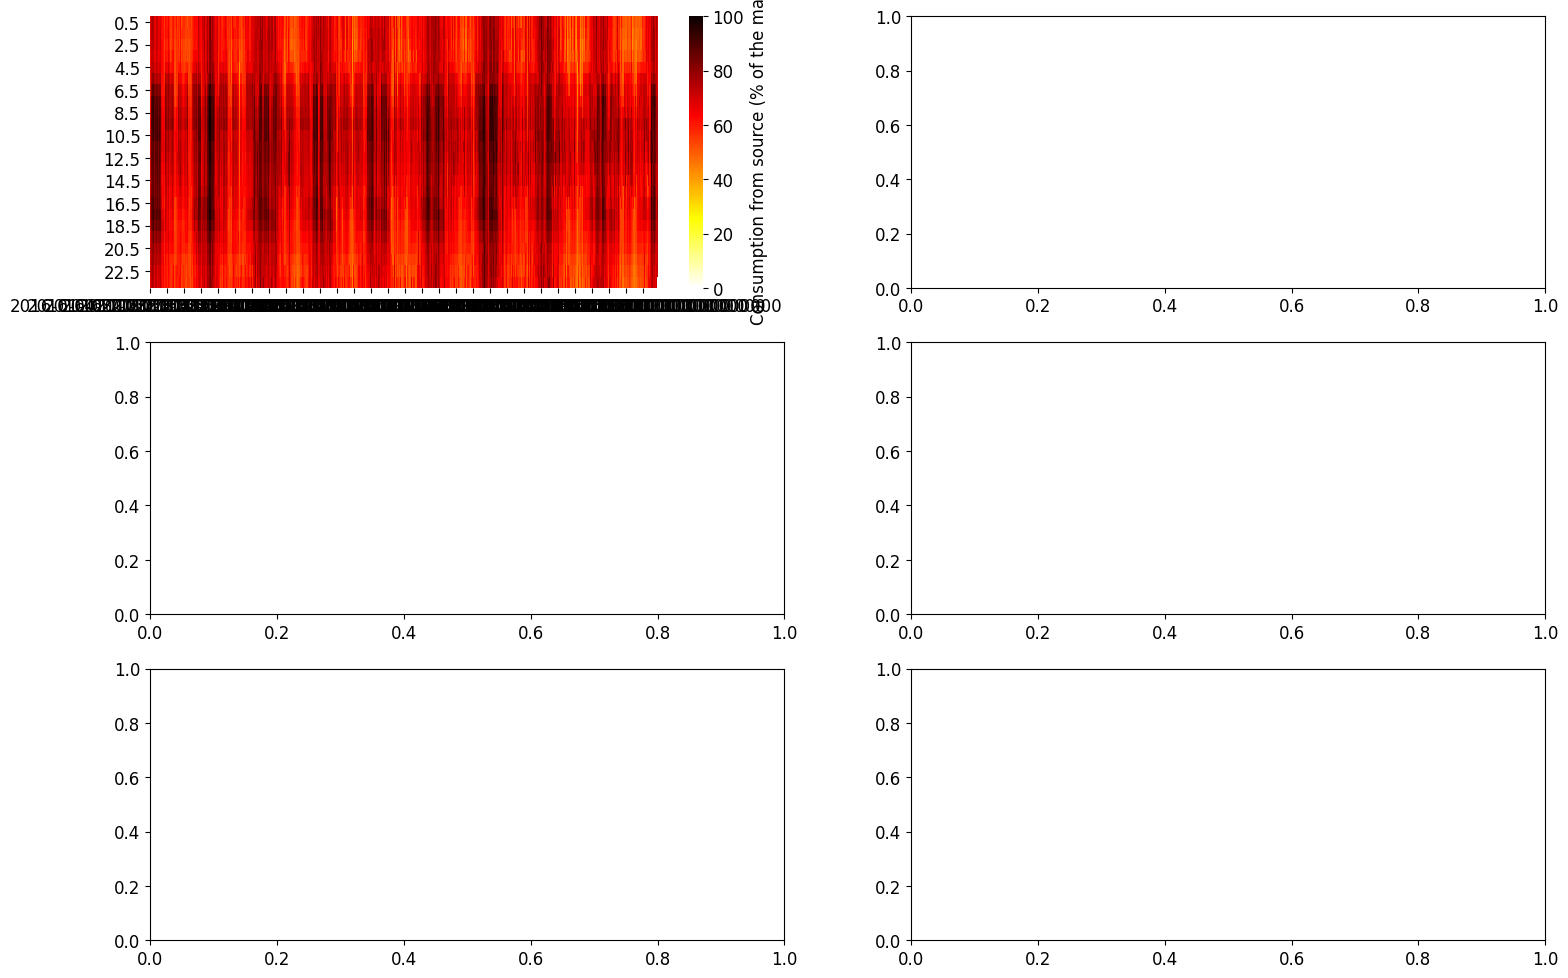

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))
countries = ['sum', 'CH', 'DE', 'FR']
# Heatmap import
data = raw_consumption_by_src['df'][countries].copy()
val_max = data[countries].max().max()
for i in range(len(countries)):
    series = data[countries[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data, countries[i], xlabels, f'Hourly imports from {countries[i]} (max power: {series.max():.0f} MW)',
                        'Consumption from source (% of the max)', val_max=100, fig=fig, ax=ax[i // 2, i % 2], relative=True)

ax[0, 0].set_title(f'Hourly total of Swiss consumption (max power: {val_max:.0f} MW)')
ax[0, 1].set_title(f'Hourly consumption of swiss electricity (max power: {data[countries[1]].max():.0f} MW)')

# Heatmap hydro
cols = ['Hydro_Pumped_Storage_CH', 'Hydro_Water_Reservoir_CH']
data2 = raw_consumption_by_src['raw_df'][cols].astype(float)
for i in range(len(cols)):
    series = data2[cols[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data2, cols[i], xlabels, f'Hourly production from {cols[i]} (max power: {series.max():.0f} MW)', 'Consumption from source (% of the max)',
                        val_max=100, fig=fig, ax=ax[2, i], relative=True)

fig.tight_layout();

Heatmap of the carbon emissions associated to the Swiss consumption mix :

C:\Users\PC Jules\AppData\Local\Temp\ipykernel_1720\3874111712.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)


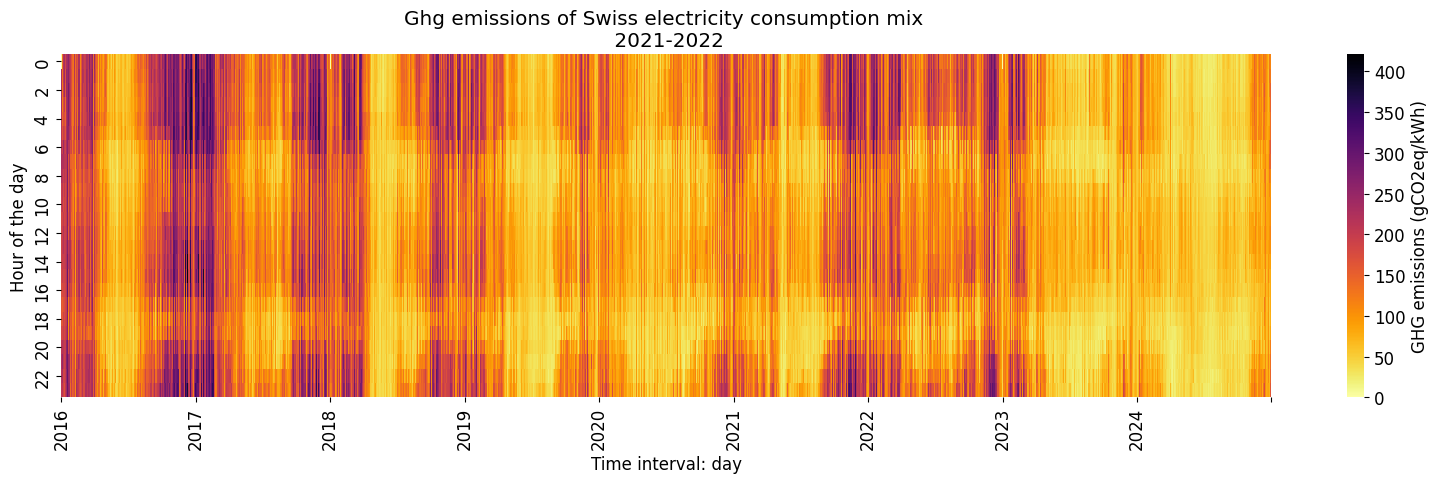

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Heatmap import
data = electricity_impact['df'][['sum']].copy()
val_min = data.min().min()
val_max = data.max().max()
series = data['sum']
xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
plot_hourly_heatmap(data, 'sum', xlabels,
                    'Ghg emissions of Swiss electricity consumption mix \n 2021-2022', 'GHG emissions (gCO2eq/kWh)',
                    val_min=val_min,
                    val_max=val_max, fig=fig, ax=ax, cmap='inferno_r')
fig.tight_layout();

Yearly average of carbon emissions per consumed kWh :
**Warning** the data before 2019 can be mis-estimated because of the lack of knowledge on the composition of the residual

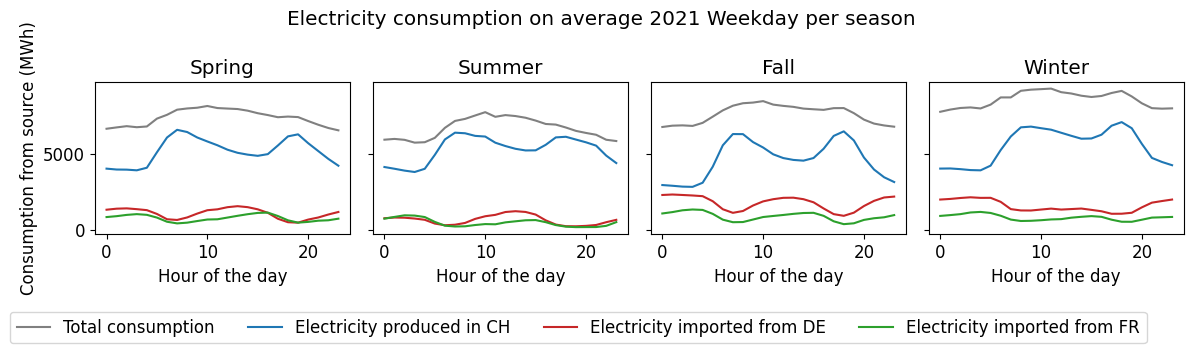

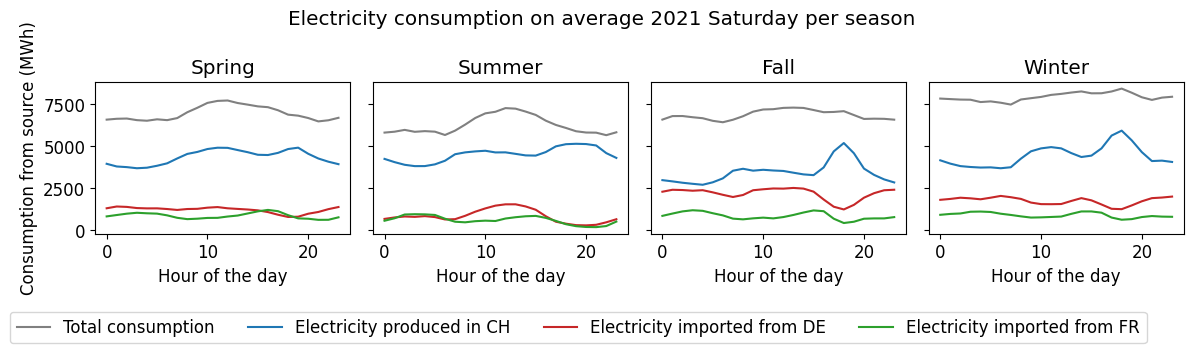

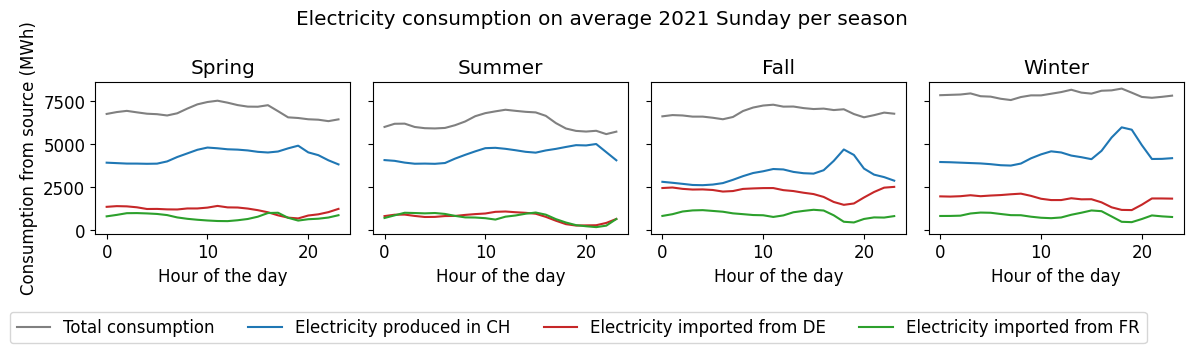

In [65]:
countries = ['sum', 'CH', 'DE', 'FR']
start = '2021-01-01'
end = '2021-12-31'
years_label = '2021'
data = raw_consumption_by_src['df'][countries].loc[start:end].copy()

season_names = {2: 'Spring', 3: 'Summer', 4: 'Fall', 1: 'Winter'}
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

season_labels = [*season_names.values()]
weekdays = ['Weekday', 'Saturday', 'Sunday']
for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels,
                          f'Electricity consumption on average {years_label} {weekdays[k]}',
                          'Consumption from source (MWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total consumption', 'Electricity produced in CH', 'Electricity imported from DE',
                'Electricity imported from FR'], loc='upper left', ncol=4, bbox_to_anchor=(0, 0))
    plt.show()

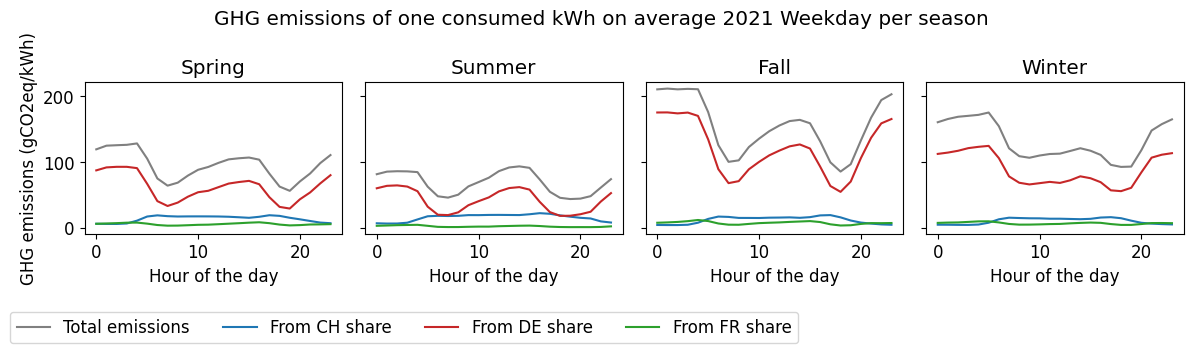

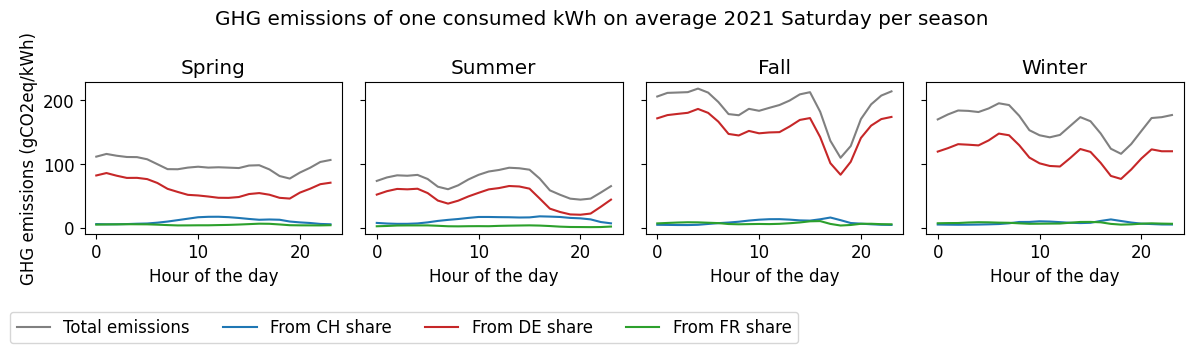

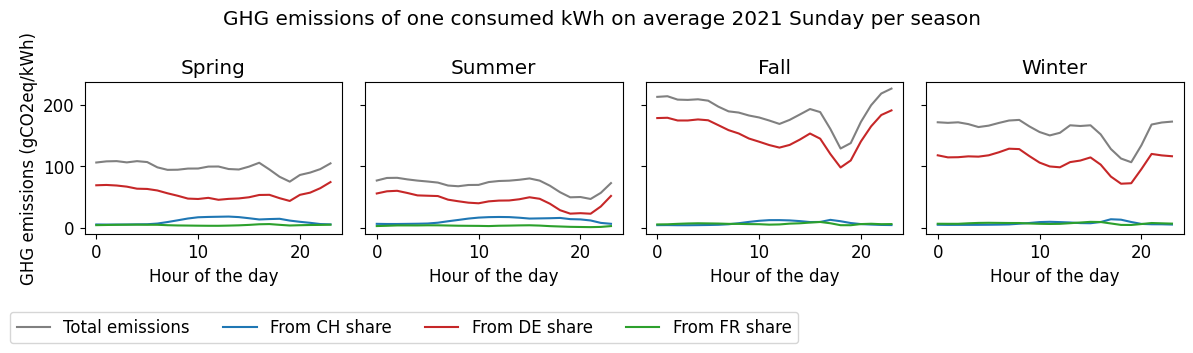

In [66]:
data = electricity_impact['df'][countries].loc[start:end].copy()
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels,
                          f'GHG emissions of one consumed kWh on average {years_label} {weekdays[k]}',
                          'GHG emissions (gCO2eq/kWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total emissions', 'From CH share', 'From DE share', 'From FR share'], loc='upper left', ncol=4,
               bbox_to_anchor=(0, 0))
    plt.show()

-- The end --